<a href="https://colab.research.google.com/github/FranciellyCastro/2D-Truss-FEM/blob/main/2D_Truss_FEM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Example of a truss with 3 elements and 3 nodes
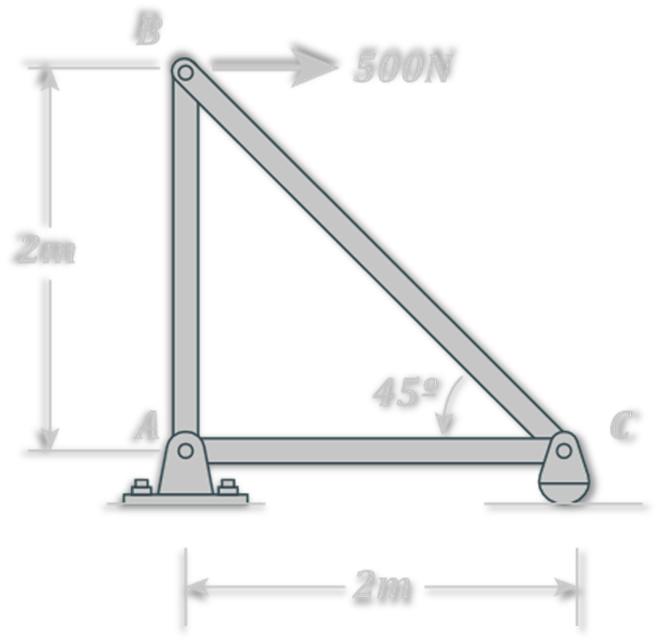

Nodal displacements at global system in mm
d 1 = 0.000000 (mm)
d 2 = 0.000000 (mm)
d 3 = 0.307387 (mm)
d 4 = 0.063662 (mm)
d 5 = 0.063662 (mm)
d 6 = 0.000000 (mm)

Strain 1  = 3.183e-5
Stress 1  = 6.366e+6 Pa
Strain 2  = -4.502e-5
Stress 2  = -9.003e+6 Pa
Strain 3  = 3.183e-5
Stress 3  = 6.366e+6 Pa

Support reactions 1 = -500.00 (N)
Support reactions 2 = -500.00 (N)
Support reactions 3 = 500.00 (N)


Text(0.5, 0, 'Length (m)')

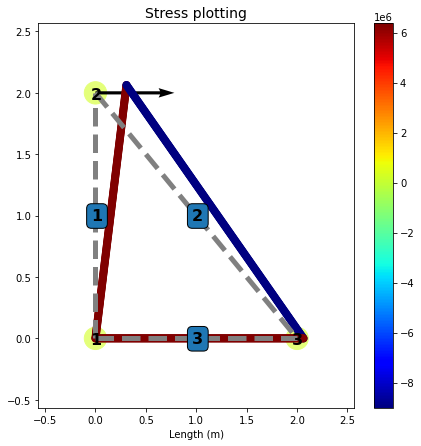

In [1]:
# Example of a truss with 3 elements and 3 nodes
# ------------------------ Pre processing --------------------------------------
import numpy as np
import copy
# 1) Defining conectivity matrix (Nels,Nnodes) and coordinates matrix (Nnodes,2)
conec = np.array([[1,2],[2,3],[1,3]]) # Conectivity matrix
coord = np.array([[0,0],[0,2],[2,0]]) # Coordinates matrix
# -----------------------------------------------------------------------------
nel = len(conec) # Number of total elements
nno = len(coord) # Number of total nodes
# -----------------------------------------------------------------------------
E = 200E9*np.ones(nel) # Elasticity module
D = 0.01*np.ones(nel)  # Diameter of the bars
# -----------------------------------------------------------------------------
# 2a) Defining the degrees of freedom (dofs) which contain the boundary conditions of displacement (Dirichlet)
# remembering the first position of a vector in python starts in 0
CCDir_gdl = [0,1,5] # For this example the degrees with boundary confitions are the first (x1) and second (y1) degrees for the node 1 and the second (y3) degree for the node 3
# 2b) Defining the freedom degrees which contain the boundary conditions of Force (Neumann) with their respective value of force
# remembering the first position of a vector in python starts in 0
F_gdl = np.array([[2,500]]) # For this example the degree with force is the first (x2) degree of the node 2 with 500 N of magnitude
# -----------------------------------------------------------------------------
# --------------------------- Processing --------------------------------------
# Superposition of Global stiffness matrix Kg
Kg = np.zeros((2*nno,2*nno)) # Oppening space for the global stiffness matrix (Ndof,Ndof)
for el in range(0,nel):
    no1 = conec[el,0]
    no2 = conec[el,1]
    Lx = coord[no2-1,0]-coord[no1-1,0]
    Ly = coord[no2-1,1]-coord[no1-1,1]
    L = np.sqrt(Lx**2+Ly**2) # Length of the current element
    Cos = Lx/L
    Sen = Ly/L
    T = np.array([[Cos,Sen,0,0],[0,0,Cos,Sen]]) # Matrix of coordinates transformation
    A = np.pi*(D[el]/2)**2 # Elementar area
    k = (E[el]*A/L)*np.array([[1,-1],[-1,1]])
    ke = np.transpose(T).dot(k).dot(T)
    # ---- Superposition of the elementary matrix at the global stiffness matrix -----
    # Finding the position of the nodal dofs at the global system
    GLel = np.array([[2*no1 - 2],[2*no1 - 1],[2*no2 - 2],[2*no2 - 1]])
    for i in range(0,len(GLel)):
        for j in range(0,len(GLel)):
            Kg[GLel[i],GLel[j]] = Kg[GLel[i],GLel[j]] + ke[i,j]         
Kg1 = copy.deepcopy(Kg) # Copping the Global stiffness matrix Kg to use for the calc of the reaction forces (support reaction) at the post process
# --- Applying the boundary conditions ----
# Boundary conditions of Force
F = np.zeros((2*nno))
for igl in range(len(F_gdl)):
  F[F_gdl[igl,0]] = F_gdl[igl,1]
# Boundary conditions of displacements
CCDir = np.zeros((2*nno,2))
for i in range(len(CCDir_gdl)):
  CCDir[CCDir_gdl[i],0] = 1   
for igl in range(2*nno):
  if CCDir[igl-1,0] == 1:
    up = CCDir[igl-1,1]  
    for i in range(2*nno): # Nullifying lines and columns which the boundary contition of displacement
      Kg[i-1,igl-1] = 0.0
      Kg[igl-1,i-1] = 0.0   
    Kg[igl-1,igl-1] = 1; # Prescribes 1 at the intersection dof of the lines and columns nullified 
# Linear system solution
d = np.linalg.solve(Kg,F)
print('Nodal displacements at global system in mm')
for igl in range(2*nno):
    print('d',igl+1, '= %.6f (mm)' % (1000*d[igl]))
print('')
# ------------------------------ Post process ----------------------------------
e = np.zeros((nel,1))
Tens = np.zeros((nel,1))
for el in range(0,nel):
    # Calc of the elementary displacements
    no1 = conec[el,0]
    no2 = conec[el,1]
    x = coord[no2-1,0]-coord[no1-1,0]
    y = coord[no2-1,1]-coord[no1-1,1]
    L = np.sqrt(x**2+y**2) # Length of the current element
    Cos = x/L
    Sen = y/L
    T = np.array([[Cos,Sen,0,0],[0,0,Cos,Sen]]) # Matrix of coordinates transformation
    d_el = np.array([d[2*no1 - 2],d[2*no1-1],d[2*no2 - 2],d[2*no2-1]])
    u = T.dot(d_el)
    # Calc of the elementary strain and stress
    e[el] = (u[1] - u[0])/L
    Tens[el] = E[el]*e[el]
    print('Strain', el+1, ' =',np.format_float_scientific(e[el], precision = 3, exp_digits=1))
    print('Stress', el+1, ' =', np.format_float_scientific(float(Tens[el]), precision = 3, exp_digits=1),'Pa')
print('')
# Calc of the support reaction using the global stiffness matrix complete (without the applied boundary conditions)
for igl in range(len(CCDir_gdl)):
    R = np.inner(Kg1[CCDir_gdl[igl],:], d.T)
    print('Support reactions',igl + 1, '= %.2f (N)' %R)
# Plotting of the results
import matplotlib.pyplot as plt
SizeSpace = (max(coord[:,0])**2 + max(coord[:,1])**2)**0.5
SF = 10 # Size factor (depending the structure this value should be changed)
fig, axs = plt.subplots(1,1,figsize=((max(coord[:,0])/SizeSpace)*SF,(max(coord[:,1])/SizeSpace)*SF))
axs.set(xlim=(-0.2*SizeSpace, max(coord[:,0])+0.2*SizeSpace), ylim=(-0.2*SizeSpace, max(coord[:,1])+0.2*SizeSpace)) 
# Plotting the initial structure
disc = 200 # Discretization
x = np.zeros((nel*disc))
y = np.zeros((nel*disc))
for el in range(0,nel):
    no1 = conec[el,0]
    no2 = conec[el,1]
    x1 = coord[no1-1,0]
    y1 = coord[no1-1,1]
    x2 = coord[no2-1,0]
    y2 = coord[no2-1,1]
    plt.plot([x1,x2],[y1,y2],color='grey',linestyle='--',linewidth=5)
# Plotting of the nodes
nox = coord[:,0]
noy = coord[:,1]
colors = 100*np.ones(nno)
plt.scatter(nox,noy,c=colors,s=500, cmap='Wistia')
# Plotting the number of each node
for i in range(nno):
    plt.text(nox[i]-max(coord[:,0])*0.025, noy[i]-max(coord[:,1])*0.025, i+1, fontsize=16,fontweight='bold')    
# Plotting the number of each element
for el in range(0,nel):
    no1 = conec[el,0]
    no2 = conec[el,1]
    x = coord[no2-1,0]-coord[no1-1,0]
    y = coord[no2-1,1]-coord[no1-1,1]
    plt.text(coord[no1-1,0]+ x/2-max(coord[:,0])*0.02, coord[no1-1,1]+y/2-max(coord[:,1])*0.02, el+1, 
             fontsize=16,fontweight='bold',bbox=dict(boxstyle="round"))  
# Plotting the forces
for ino in range(0,nno):
  if F[2*ino] != 0:
    xix = coord[ino,0]
    yix = coord[ino,1]
    xfx = F[2*ino]/abs(F[2*ino])
    yfx = 0
    plt.quiver(xix,yix,xfx,yfx,scale = 2*max(coord[:,0]),width=0.01)
  if F[2*ino+1] != 0:
    xiy = coord[ino,0]
    yiy = coord[ino,1]
    xfy = 0
    yfy = F[2*ino+1]/abs(F[2*ino+1])
    plt.quiver(xiy,yiy,xfy,yfy,scale = 2*max(coord[:,1]),width=0.01) 
# Plotting the deformed structure  
disc = 200 # Discretization
x = np.zeros((nel*disc))
y = np.zeros((nel*disc))
colors = np.zeros((nel*disc))
diamplot = np.zeros((nel*disc))
for el in range(0,nel):
    no1 = conec[el,0]
    no2 = conec[el,1]
    x1 = coord[no1-1,0] + 1000*d[2*no1 - 2] 
    y1 = coord[no1-1,1] + 1000*d[2*no1-1]
    x2 = coord[no2-1,0] + 1000*d[2*no2 - 2]
    y2 = coord[no2-1,1] + 1000*d[2*no2-1]
    x_aux = np.asfarray(np.linspace(x1,x2,disc), dtype='float')
    y_aux = np.asfarray(np.linspace(y1,y2,disc), dtype='float')
    for j in range(0,disc):
        x[disc*(el+1)-disc+j] = x_aux[j]
        y[disc*(el+1)-disc+j] = y_aux[j]
        colors[disc*(el+1)-disc+j] = Tens[el]
        diamplot[disc*(el+1)-disc+j] = 5e3*D[el]  
plt.scatter(x,y,c=colors,s=diamplot, cmap='jet') 
plt.colorbar()     
plt.title("Stress plotting", fontsize=14)
plt.xlabel('Length (m)')

# Example of size optimization code for a truss with 3 elements and 3 nodes
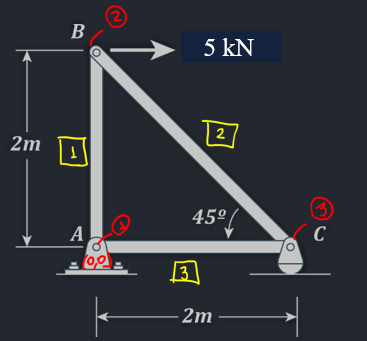

Total mass of the initial truss = 4.231 kg

The optimum total mass of the truss = 1.262 kg

D 1 = 5.0463 (mm)
D 2 = 6.0011 (mm)
D 3 = 5.0463 (mm)

Stress 1 = 250.0000 (MPa)
Stress 2 = -250.0001 (MPa)
Stress 3 = 250.0000 (MPa)


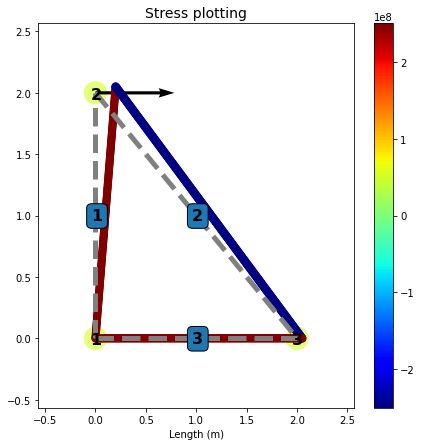

In [3]:
# This code search a size optimization of 2D trusses
# Example of a truss with 3 elements and 3 nodes
# ------------------------ Pre processing --------------------------------------
import numpy as np
import scipy as sp
from scipy import optimize
import copy
# 1) Defining conectivity matrix (Nels,Nnodes) and coordinates matrix (Nnodes,2)
conec = np.array([[1,2],[2,3],[1,3]]) # Conectivity matrix
coord = np.array([[0,0],[0,2],[2,0]]) # Coordinates matrix
# -----------------------------------------------------------------------------
nel = len(conec) # Number of total elements
nno = len(coord) # Number of total nodes
# -----------------------------------------------------------------------------
E = 200E9*np.ones(nel) # Elasticity module
# -----------------------------------------------------------------------------
# 2) Parameters to be defined for the optimization process
# Defining the  material density for the calc of the total mass of the structure
dens = 7890 # Material density in kg/m³
# Defining the yield stress of the material for the calc of the constraints at the optimization process
Tesc = 250E6 # Yield stress of the steel A36 in MPa
# Defining the initial diameter of the bars to be optimized
D0 = 0.01*np.ones(nel)
# Defining the inferior and superior limits for design variable (which are the diameters of the bars)
b = (0.002,0.05) # For this example was assumed 2 mm as minimum and 50 mm as maximum diameter
# -----------------------------------------------------------------------------
# Inserting these limits for all elements of the structure
limites = np.zeros((nel,2))
for el in range(0,nel):
  limites[el,:] = b
# ------------------------------------------------------------------------------
# 3a) Defining the degrees of freedom (dofs) which contain the boundary conditions of displacement (Dirichlet)
# remembering the first position of a vector in python starts in 0
CCDir_gdl = [0,1,5] 
# 3b) Defining the freedom degrees which contain the boundary conditions of Force (Neumann) with their respective value of force
# remembering the first position of a vector in python starts in 0
F_gdl = np.array([[2,5000]])
# -----------------------------------------------------------------------------
# Calc of the initial mass of the structure considering D0 
massai = 0 
for el in range(0,nel):
    no1 = conec[el,0]
    no2 = conec[el,1]
    x = coord[no2-1,0]-coord[no1-1,0]
    y = coord[no2-1,1]-coord[no1-1,1]
    L = np.sqrt(x**2+y**2) # Length of the current element
    A = np.pi*(D0[el]/2)**2 # Elementar area
    massai = massai + dens*A*L
print('Total mass of the initial truss = %.3f' % massai, 'kg')
# Plotting the initial structure
import matplotlib.pyplot as plt
SizeSpace = (max(coord[:,0])**2 + max(coord[:,1])**2)**0.5
SF = 10 # Size factor (depending the structure this value should be changed)
fig, axs = plt.subplots(1,1,figsize=((max(coord[:,0])/SizeSpace)*SF,(max(coord[:,1])/SizeSpace)*SF))
axs.set(xlim=(-0.2*SizeSpace, max(coord[:,0])+0.2*SizeSpace), ylim=(-0.2*SizeSpace, max(coord[:,1])+0.2*SizeSpace)) 
disc = 200 # Discretization
x = np.zeros((nel*disc))
y = np.zeros((nel*disc))
for el in range(0,nel):
    no1 = conec[el,0]
    no2 = conec[el,1]
    x1 = coord[no1-1,0]
    y1 = coord[no1-1,1]
    x2 = coord[no2-1,0]
    y2 = coord[no2-1,1]
    plt.plot([x1,x2],[y1,y2],color='grey',linestyle='--',linewidth=5)
# Plotting of the nodes
nox = coord[:,0]
noy = coord[:,1]
colors = 100*np.ones(nno)
plt.scatter(nox,noy,c=colors,s=500, cmap='Wistia')
# Plotting the number of each node
for i in range(nno):
    plt.text(nox[i]-max(coord[:,0])*0.025, noy[i]-max(coord[:,1])*0.025, i+1, fontsize=16,fontweight='bold')    
# Plotting the number of each element
for el in range(0,nel):
    no1 = conec[el,0]
    no2 = conec[el,1]
    x = coord[no2-1,0]-coord[no1-1,0]
    y = coord[no2-1,1]-coord[no1-1,1]
    plt.text(coord[no1-1,0]+ x/2-max(coord[:,0])*0.02, coord[no1-1,1]+y/2-max(coord[:,1])*0.02, el+1, 
             fontsize=16,fontweight='bold',bbox=dict(boxstyle="round"))       
plt.title("Stress plotting", fontsize=14)
plt.xlabel('Length (m)')  
# Size optimization algorithm for 2D trusses
# Objective function calc (total mass of truss)
def funobj(D):
  massa = 0
  for el in range(0,nel):
      no1 = conec[el,0]
      no2 = conec[el,1]
      x = coord[no2-1,0]-coord[no1-1,0]
      y = coord[no2-1,1]-coord[no1-1,1]
      L = np.sqrt(x**2+y**2) # Length of the current element
      A = np.pi*(D[el]/2)**2 # Elementar area
      massa = massa + dens*A*L
  return massa
# Stresses calc for the constraints analysis  
def Tensao(D):
  Kg = np.zeros((2*nno,2*nno)) # Oppening space for the global stiffness matrix (Ndof,Ndof)
  for el in range(0,nel):
      no1 = conec[el,0]
      no2 = conec[el,1]
      x = coord[no2-1,0]-coord[no1-1,0]
      y = coord[no2-1,1]-coord[no1-1,1]
      L = np.sqrt(x**2+y**2) # Length of the current element
      Cos = x/L
      Sen = y/L
      T = np.array([[Cos,Sen,0,0],[0,0,Cos,Sen]]) # Matrix of coordinates transformation
      A = np.pi*(D[el]/2)**2 # Elementar area
      k = (E[el]*A/L)*np.array([[1,-1],[-1,1]])
      ke = np.transpose(T).dot(k).dot(T)
      # ---- Superposition of the elementary matrix at the global stiffness matrix -----
      # Finding the position of the nodal dofs at the global system
      GLel = np.array([[2*no1 - 2],[2*no1 - 1],[2*no2 - 2],[2*no2 - 1]])
      for i in range(0,len(GLel)):
          for j in range(0,len(GLel)):
              Kg[GLel[i],GLel[j]] = Kg[GLel[i],GLel[j]] + ke[i,j]         
  # --- Applying the boundary conditions ----
  # Boundary conditions of Force
  F = np.zeros((2*nno))
  for igl in range(len(F_gdl)):
    F[F_gdl[igl,0]] = F_gdl[igl,1]
  # Boundary conditions of displacements
  CCDir = np.zeros((2*nno,2))
  for i in range(len(CCDir_gdl)):
      CCDir[CCDir_gdl[i],0] = 1   
  for igl in range(2*nno):
      if CCDir[igl-1,0] == 1:
        up = CCDir[igl-1,1]  
        for i in range(2*nno): # Nullifying lines and columns which the boundary contition of displacement
            Kg[i-1,igl-1] = 0.0
            Kg[igl-1,i-1] = 0.0   
        Kg[igl-1,igl-1] = 1; # Prescribes 1 at the intersection dof of the lines and columns nullified 
  # Linear system solution
  d = np.linalg.solve(Kg,F)
  # ------------------------------ Post process ----------------------------------
  e = np.zeros((nel,1))
  Tens = np.zeros((nel,1))
  # Calc of the elementary displacements
  for el in range(0,nel):
    no1 = conec[el,0]
    no2 = conec[el,1]
    x = coord[no2-1,0]-coord[no1-1,0]
    y = coord[no2-1,1]-coord[no1-1,1]
    L = np.sqrt(x**2+y**2) # Length of the current element
    Cos = x/L
    Sen = y/L
    T = np.array([[Cos,Sen,0,0],[0,0,Cos,Sen]]) # Matrix of coordinates transformation
    d_el = np.array([d[2*no1 - 2],d[2*no1-1],d[2*no2 - 2],d[2*no2-1]])
    u = T.dot(d_el)
    # Calc of the elementary strain and stress
    e[el] = (u[1] - u[0])/L
    Tens[el] = E[el]*e[el]
  return Tens, d, F
# Constraints calc
def restricoes(D):
  Tens, d, F = Tensao(D)
  restricao = np.zeros((nel))
  StrNormTra = 1/Tesc # Normalizing the stress
  StrNormCom = 1/Tesc
  for el in range(0,nel):
    if Tens[el] >= 0:
      restricao[el] = StrNormTra*(Tesc - float(Tens[el]))
    else:
      restricao[el] = StrNormCom*(float(Tens[el]) + Tesc)
  return restricao 
cons = ({'type': 'ineq', 'fun': restricoes}) # Restrições = constraints
# Solving the optimization problem using the function optimize.minimize
sol = sp.optimize.minimize(funobj,D0,method='SLSQP',bounds=limites,constraints=cons,tol = 1E-6)
# print(sol)
print('')
print('The optimum total mass of the truss = %.3f' % sol.fun, 'kg')
print('')
# Printing the optimum diameter in (mm)
for el in range(0,nel):
  print('D',el + 1, '= %.4f (mm)' %(1000*sol.x[el]))
Tens, d, F = Tensao(sol.x)  
print('')
# Printing the stress at each bar in (MPa)
for el in range(0,nel):  
  print('Stress',el + 1, '= %.4f (MPa)' %(Tens[el]/1E6))
# Plotting the forces
for ino in range(0,nno):
  if F[2*ino] != 0:
    xix = coord[ino,0]
    yix = coord[ino,1]
    xfx = F[2*ino]/abs(F[2*ino])
    yfx = 0
    plt.quiver(xix,yix,xfx,yfx,scale = 2*max(coord[:,0]),width=0.01)
  if F[2*ino+1] != 0:
    xiy = coord[ino,0]
    yiy = coord[ino,1]
    xfy = 0
    yfy = F[2*ino+1]/abs(F[2*ino+1])
    plt.quiver(xiy,yiy,xfy,yfy,scale = 2*max(coord[:,1]),width=0.01)   
# Plotting the final structure with the optimum diameters (D)
disc = 200 # Discretization
x = np.zeros((nel*disc))
y = np.zeros((nel*disc))
colors = np.zeros((nel*disc))
diamplot = np.zeros((nel*disc))
for el in range(0,nel):
    no1 = conec[el,0]
    no2 = conec[el,1]
    x1 = coord[no1-1,0] + 20*d[2*no1 - 2] 
    y1 = coord[no1-1,1] + 20*d[2*no1-1]
    x2 = coord[no2-1,0] + 20*d[2*no2 - 2]
    y2 = coord[no2-1,1] + 20*d[2*no2-1]
    x_aux = np.asfarray(np.linspace(x1,x2,disc), dtype='float')
    y_aux = np.asfarray(np.linspace(y1,y2,disc), dtype='float')
    for j in range(0,disc):
        x[disc*(el+1)-disc+j] = x_aux[j]
        y[disc*(el+1)-disc+j] = y_aux[j]
        colors[disc*(el+1)-disc+j] = Tens[el]
        diamplot[disc*(el+1)-disc+j] = 1e4*sol.x[el]  
plt.scatter(x,y,c=colors,s=diamplot, cmap='jet') 
plt.colorbar()

# Example of size optimization code for a truss with 13 elements and 8 nodes
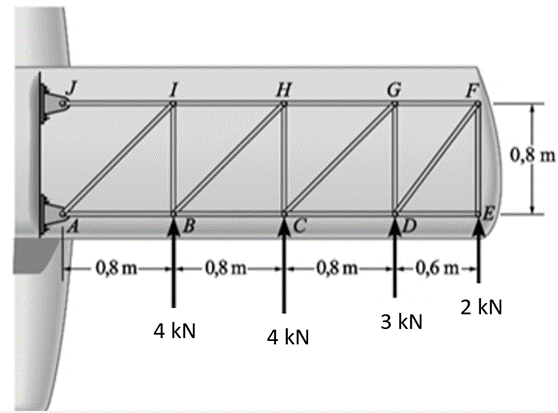

Total mass of the initial truss = 2.893 kg

The optimum total mass of the truss = 1.376 kg

D 1 = 8.7973 (mm)
D 2 = 5.6969 (mm)
D 3 = 2.7367 (mm)
D 4 = 2.0000 (mm)
D 5 = 3.1601 (mm)
D 6 = 3.5331 (mm)
D 7 = 4.9965 (mm)
D 8 = 5.9419 (mm)
D 9 = 6.7036 (mm)
D 10 = 7.9719 (mm)
D 11 = 8.0567 (mm)
D 12 = 9.5811 (mm)
D 13 = 11.9291 (mm)
D 14 = 8.7973 (mm)
D 15 = 5.6969 (mm)
D 16 = 2.7367 (mm)

Stress 1 = 255.0000 (MPa)
Stress 2 = 255.0005 (MPa)
Stress 3 = 255.0000 (MPa)
Stress 4 = 0.0000 (MPa)
Stress 5 = -255.0000 (MPa)
Stress 6 = 255.0000 (MPa)
Stress 7 = -255.0000 (MPa)
Stress 8 = 255.0013 (MPa)
Stress 9 = -255.0000 (MPa)
Stress 10 = 255.0000 (MPa)
Stress 11 = -255.0000 (MPa)
Stress 12 = 255.0000 (MPa)
Stress 13 = -255.0000 (MPa)
Stress 14 = -255.0000 (MPa)
Stress 15 = -255.0005 (MPa)
Stress 16 = -255.0000 (MPa)


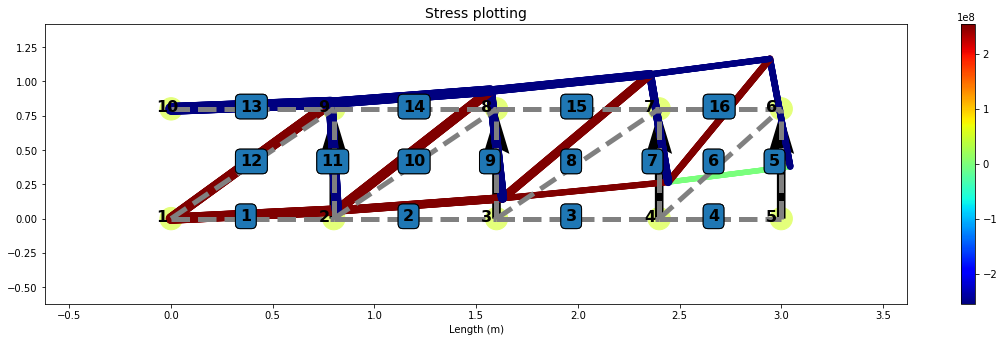

In [6]:
# This code search a size optimization of 2D trusses
# Example of a truss with 16 elements and 10 nodes
# ------------------------ Pre processing -------------------------------------- 
import numpy as np
import scipy as sp
from scipy import optimize
import copy
# 1) Defining conectivity matrix (Nels,Nnodes) and coordinates matrix (Nnodes,2)
conec = np.array([[1,2],[2,3],[3,4],[4,5],[5,6],[4,6],[4,7],[3,7],[3,8],[2,8],[2,9],[1,9],[10,9],[9,8],[8,7],[7,6]]) # Conectivity matrix
coord = np.array([[0,0],[0.8,0],[1.6,0],[2.4,0],[3,0],[3,0.8],[2.4,0.8],[1.6,0.8],[0.8,0.8],[0,0.8]]) # Coordinates matrix
# -----------------------------------------------------------------------------
nel = len(conec) # Number of total elements
nno = len(coord) # Number of total nodes
# -----------------------------------------------------------------------------
E = 68.9E9*np.ones(nel) # Elasticity module
# -----------------------------------------------------------------------------
# 2) Parameters to be defined for the optimization process
# Defining the  material density for the calc of the total mass of the structure
dens = 2710 # Material density in kg/m³
# Defining the yield stress of the material for the calc of the constraints at the optimization process
Tesc = 255E6 # Yield stress of the Aluminium in MPa
# Defining the initial diameter of the bars to be optimized
D0 = 0.01*np.ones(nel)
# Defining the inferior and superior limits for design variable (which are the diameters of the bars)
b = (0.002,0.05)
# -----------------------------------------------------------------------------
# Inserting these limits for all elements of the structure
limites = np.zeros((nel,2))
for el in range(0,nel):
  limites[el,:] = b
# -----------------------------------------------------------------------------
# 3a) Defining the degrees of freedom (dofs) which contain the boundary conditions of displacement (Dirichlet)
# remembering the first position of a vector in python starts in 0
CCDir_gdl = [0,1,18,19]
# 3b) Defining the freedom degrees which contain the boundary conditions of Force (Neumann) with their respective value of force
# remembering the first position of a vector in python starts in 0
F_gdl = np.array([[3,4000],[5,4000],[7,3000],[9,2000]])
# -----------------------------------------------------------------------------
# Calc of the initial mass of the structure considering D0 
massai = 0 
for el in range(0,nel):
    no1 = conec[el,0]
    no2 = conec[el,1]
    x = coord[no2-1,0]-coord[no1-1,0]
    y = coord[no2-1,1]-coord[no1-1,1]
    L = np.sqrt(x**2+y**2) # Length of the current element
    Cos = x/L
    Sen = y/L
    T = np.array([[Cos,Sen,0,0],[0,0,Cos,Sen]]) # Matriz de transformação de coordenadas
    A = np.pi*(D0[el]/2)**2 # Elementar area
    massai = massai + dens*A*L
print('Total mass of the initial truss = %.3f' % massai, 'kg')
# Plotting the initial structure
import matplotlib.pyplot as plt
SizeSpace = (max(coord[:,0])**2 + max(coord[:,1])**2)**0.5
SF = 20 # Size factor (depending the structure this value should be changed)
fig, axs = plt.subplots(1,1,figsize=((max(coord[:,0])/SizeSpace)*SF,(max(coord[:,1])/SizeSpace)*SF))
axs.set(xlim=(-0.2*SizeSpace, max(coord[:,0])+0.2*SizeSpace), ylim=(-0.2*SizeSpace, max(coord[:,1])+0.2*SizeSpace)) 
disc = 200 # Discretization
x = np.zeros((nel*disc))
y = np.zeros((nel*disc))
for el in range(0,nel):
    no1 = conec[el,0]
    no2 = conec[el,1]
    x1 = coord[no1-1,0]
    y1 = coord[no1-1,1]
    x2 = coord[no2-1,0]
    y2 = coord[no2-1,1]
    plt.plot([x1,x2],[y1,y2],color='grey',linestyle='--',linewidth=5)
# Plotting of the nodes
nox = coord[:,0]
noy = coord[:,1]
colors = 100*np.ones(nno)
plt.scatter(nox,noy,c=colors,s=500, cmap='Wistia')
# Plotting the number of each node
for i in range(nno):
    plt.text(nox[i]-max(coord[:,0])*0.025, noy[i]-max(coord[:,1])*0.025, i+1, fontsize=16,fontweight='bold')    
# Plotting of the element
for el in range(0,nel):
    no1 = conec[el,0]
    no2 = conec[el,1]
    x = coord[no2-1,0]-coord[no1-1,0]
    y = coord[no2-1,1]-coord[no1-1,1]
    plt.text(coord[no1-1,0]+ x/2-max(coord[:,0])*0.02, coord[no1-1,1]+y/2-max(coord[:,1])*0.02, el+1, 
             fontsize=16,fontweight='bold',bbox=dict(boxstyle="round"))    
# Plotting the number of each element
for el in range(0,nel):
    no1 = conec[el,0]
    no2 = conec[el,1]
    x = coord[no2-1,0]-coord[no1-1,0]
    y = coord[no2-1,1]-coord[no1-1,1]
    plt.text(coord[no1-1,0]+ x/2-max(coord[:,0])*0.02, coord[no1-1,1]+y/2-max(coord[:,1])*0.02, 
             el+1, fontsize=16,fontweight='bold',bbox=dict(boxstyle="round"))       
plt.title("Stress plotting", fontsize=14)
plt.xlabel('Length (m)')   
# Size optimization algorithm for 2D trusses
# Objective function calc (total mass of truss)
def funobj(D):
  massa = 0
  for el in range(0,nel):
      no1 = conec[el,0]
      no2 = conec[el,1]
      x = coord[no2-1,0]-coord[no1-1,0]
      y = coord[no2-1,1]-coord[no1-1,1]
      L = np.sqrt(x**2+y**2) # Length of the current element
      Cos = x/L
      Sen = y/L
      T = np.array([[Cos,Sen,0,0],[0,0,Cos,Sen]]) # Matrix of coordinates transformation
      A = np.pi*(D[el]/2)**2 # Elementar area
      massa = massa + dens*A*L
  return massa
# Stresses calc for the constraints analysis  
def Tensao(D):
  Kg = np.zeros((2*nno,2*nno)) # Oppening space for the global stiffness matrix (Ndof,Ndof)
  for el in range(0,nel):
      no1 = conec[el,0]
      no2 = conec[el,1]
      x = coord[no2-1,0]-coord[no1-1,0]
      y = coord[no2-1,1]-coord[no1-1,1]
      L = np.sqrt(x**2+y**2) # Length of the current element
      Cos = x/L
      Sen = y/L
      T = np.array([[Cos,Sen,0,0],[0,0,Cos,Sen]]) # Matrix of coordinates transformation
      A = np.pi*(D[el]/2)**2 # Elementar area
      k = (E[el]*A/L)*np.array([[1,-1],[-1,1]])
      ke = np.transpose(T).dot(k).dot(T)
      # ---- Superposition of the elementary matrix at the global stiffness matrix -----
      # Finding the position of the nodal dofs at the global system
      GLel = np.array([[2*no1 - 2],[2*no1 - 1],[2*no2 - 2],[2*no2 - 1]])
      for i in range(0,len(GLel)):
          for j in range(0,len(GLel)):
              Kg[GLel[i],GLel[j]] = Kg[GLel[i],GLel[j]] + ke[i,j]         
  Kg1 = copy.deepcopy(Kg)
  # --- Applying the boundary conditions ----
  # Boundary conditions of Force
  F = np.zeros((2*nno))
  for igl in range(len(F_gdl)):
    F[F_gdl[igl,0]] = F_gdl[igl,1]
  # Boundary conditions of displacements
  CCDir = np.zeros((2*nno,2))
  for i in range(len(CCDir_gdl)):
      CCDir[CCDir_gdl[i],0] = 1   
  for igl in range(2*nno):
      if CCDir[igl-1,0] == 1:
        up = CCDir[igl-1,1]  
        for i in range(2*nno): # Nullifying lines and columns which the boundary contition of displacement
            Kg[i-1,igl-1] = 0.0
            Kg[igl-1,i-1] = 0.0   
        Kg[igl-1,igl-1] = 1; # Prescribes 1 at the intersection dof of the lines and columns nullified  
  # Linear system solution
  d = np.linalg.solve(Kg,F)
  # ------------------------------ Post process ----------------------------------
  e = np.zeros((nel,1))
  Tens = np.zeros((nel,1))
  # Calc of the elementary displacements
  for el in range(0,nel):
    no1 = conec[el,0]
    no2 = conec[el,1]
    x = coord[no2-1,0]-coord[no1-1,0]
    y = coord[no2-1,1]-coord[no1-1,1]
    L = np.sqrt(x**2+y**2) # Length of the current element
    Cos = x/L
    Sen = y/L
    T = np.array([[Cos,Sen,0,0],[0,0,Cos,Sen]]) # Matrix of coordinates transformation
    d_el = np.array([d[2*no1 - 2],d[2*no1-1],d[2*no2 - 2],d[2*no2-1]])
    u = T.dot(d_el)
    # Calc of the elementary strain and stress
    e[el] = (u[1] - u[0])/L
    Tens[el] = E[el]*e[el]
  return Tens, d, F
# Constraints calc
def restricoes(D):
  Tens, d, F = Tensao(D)
  restricao = np.zeros((nel))
  StrNormTra = 1/Tesc # Normalizing the stress
  StrNormCom = 1/Tesc
  for el in range(0,nel):
    if Tens[el] >= 0:
      restricao[el] = StrNormTra*(Tesc - float(Tens[el]))
    else:
      restricao[el] = StrNormCom*(float(Tens[el]) + Tesc)
  return restricao 
cons = ({'type': 'ineq', 'fun': restricoes})
# Solving the optimization problem using the function optimize.minimize
sol = sp.optimize.minimize(funobj,D0,method='SLSQP',bounds=limites,constraints=cons,tol = 1E-6)
#print(sol)
print('')
print('The optimum total mass of the truss = %.3f' % sol.fun, 'kg')
print('')
# Printing the optimum diameter in (mm)
for el in range(0,nel):
  print('D',el + 1, '= %.4f (mm)' %(1000*sol.x[el]))
Tens, d, F = Tensao(sol.x)  
print('')
# Printing the stress at each bar in (MPa)
for el in range(0,nel):  
  print('Stress',el + 1, '= %.4f (MPa)' %(Tens[el]/1E6))
# Plotting the forces
for ino in range(0,nno):
  if F[2*ino] != 0:
    xix = coord[ino,0]
    yix = coord[ino,1]
    xfx = F[2*ino]/abs(F[2*ino])
    yfx = 0
    plt.quiver(xix,yix,xfx,yfx,scale = 10*max(coord[:,0]),width=0.01)
  if F[2*ino+1] != 0:
    xiy = coord[ino,0]
    yiy = coord[ino,1]
    xfy = 0
    yfy = F[2*ino+1]/abs(F[2*ino+1])
    plt.quiver(xiy,yiy,xfy,yfy,scale = 10*max(coord[:,1]),width=0.01)   
# Plotting the final structure with the optimum diameters (D)
disc = 200 # Discretization
x = np.zeros((nel*disc))
y = np.zeros((nel*disc))
colors = np.zeros((nel*disc))
diamplot = np.zeros((nel*disc))
for el in range(0,nel):
    no1 = conec[el,0]
    no2 = conec[el,1]
    x1 = coord[no1-1,0] + 5*d[2*no1 - 2] 
    y1 = coord[no1-1,1] + 5*d[2*no1-1]
    x2 = coord[no2-1,0] + 5*d[2*no2 - 2]
    y2 = coord[no2-1,1] + 5*d[2*no2-1]
    x_aux = np.asfarray(np.linspace(x1,x2,disc), dtype='float')
    y_aux = np.asfarray(np.linspace(y1,y2,disc), dtype='float')
    for j in range(0,disc):
        x[disc*(el+1)-disc+j] = x_aux[j]
        y[disc*(el+1)-disc+j] = y_aux[j]
        colors[disc*(el+1)-disc+j] = Tens[el]
        diamplot[disc*(el+1)-disc+j] = 1e4*sol.x[el]  
plt.scatter(x,y,c=colors,s=diamplot, cmap='jet') 
plt.colorbar()